In [109]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import numpy as np

# Mac에서는 "AppleGothic" 사용
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

In [111]:
import pandas as pd

# 불러오기
base_df = pd.read_parquet("../data/train/3.승인매출정보/201812_train_승인매출정보.parquet")

print(base_df.head())

     기준년월            ID  최종이용일자_기본  최종이용일자_신판  최종이용일자_CA  최종이용일자_카드론  \
0  201812  TRAIN_000000   20181224   20181224   20181221       10101   
1  201812  TRAIN_000001   20181214   20181214   20170728    20170327   
2  201812  TRAIN_000002   20181228   20181228   20181216    20151119   
3  201812  TRAIN_000003   20181221   20181212   20181221       10101   
4  201812  TRAIN_000004   20180905   20180905      10101       10101   

   최종이용일자_체크  최종이용일자_일시불  최종이용일자_할부  이용건수_신용_B0M  ...  승인거절건수_한도초과_B0M  \
0   20180203    20181224   20180713            7  ...                0   
1      10101    20181214   20171231            9  ...                0   
2   20141230    20181228   20181115           20  ...                0   
3   20141111    20181203   20181212           12  ...                0   
4   20181210    20180905      10101            0  ...                0   

   승인거절건수_BL_B0M  승인거절건수_입력오류_B0M  승인거절건수_기타_B0M  승인거절건수_R3M  승인거절건수_한도초과_R3M  \
0              0                0        

In [113]:
# 1. Segment 정보 불러오기
member_df = pd.read_parquet("../data/train/1.회원정보/201812_train_회원정보.parquet", columns=["ID", "Segment", "입회경과개월수_신용"])

# 2. 병합
df = pd.merge(base_df, member_df, on="ID", how="left")

# 3. 결과
df

,기준년월,ID,최종이용일자_기본,최종이용일자_신판,최종이용일자_CA,최종이용일자_카드론,최종이용일자_체크,최종이용일자_일시불,최종이용일자_할부,이용건수_신용_B0M,...,승인거절건수_입력오류_B0M,승인거절건수_기타_B0M,승인거절건수_R3M,승인거절건수_한도초과_R3M,승인거절건수_BL_R3M,승인거절건수_입력오류_R3M,승인거절건수_기타_R3M,이용금액대,Segment,입회경과개월수_신용
0,201812,TRAIN_000000,20181224,20181224,20181221,10101,20180203,20181224,20180713,7,...,0,0,0,0,0,0,0,01.100만원+,D,71
1,201812,TRAIN_000001,20181214,20181214,20170728,20170327,10101,20181214,20171231,9,...,0,0,0,0,0,0,0,03.30만원+,E,16
2,201812,TRAIN_000002,20181228,20181228,20181216,20151119,20141230,20181228,20181115,20,...,0,0,0,0,0,0,0,01.100만원+,C,128
3,201812,TRAIN_000003,20181221,20181212,20181221,10101,20141111,20181203,20181212,12,...,0,0,0,0,0,0,0,01.100만원+,D,31
4,201812,TRAIN_000004,20180905,20180905,10101,10101,20181210,20180905,10101,0,...,0,0,0,0,0,0,0,05.10만원-,E,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,201812,TRAIN_399995,20181220,20181220,10101,10101,20181212,20181220,20160501,2,...,0,0,0,0,0,0,0,09.미사용,E,209
399996,201812,TRAIN_399996,20181202,20181202,10101,20170112,10101,20181202,20180112,10,...,0,0,0,0,0,0,0,01.100만원+,D,17
399997,201812,TRAIN_399997,20181230,20181230,10101,10101,20131124,20181230,20180919,10,...,0,0,0,0,0,0,0,02.50만원+,C,115
399998,201812,TRAIN_399998,20161224,20161224,10101,10101,10101,20161224,20150122,-2,...,0,0,0,0,0,0,0,09.미사용,E,71


In [134]:
# Recency
recency_cols = [
    '입회경과개월수_신용'
]

# Frequency (최근 6개월간 이용건수)
frequency_cols = [
    '이용건수_신용_R6M',
]

# Monetary (최근 6개월간 총 이용금액)
monetary_cols = [
    '이용금액_일시불_R6M',
    '이용금액_할부_R6M',
    '이용금액_CA_R6M',
    '이용금액_체크_R6M',
    '이용금액_카드론_R6M'
]

# 최종 컬럼 목록
rfm_cols = ['ID'] + recency_cols + frequency_cols + monetary_cols

In [136]:
# 가장 최근 사용한 카드 유형의 경과월만 사용 (예: 3개 중 최소값)
df['Recency'] = df[recency_cols].min(axis=1)

df['Frequency'] = df[frequency_cols].sum(axis=1)
df['Monetary'] = df[monetary_cols].sum(axis=1)

In [138]:
print(df[['ID', 'Recency', 'Frequency', 'Monetary']].head())

             ID  Recency  Frequency  Monetary
0  TRAIN_000000       71         46     81163
1  TRAIN_000001       16         67     16556
2  TRAIN_000002      128        106    136345
3  TRAIN_000003       31         54     99929
4  TRAIN_000004        6         -3     18535


## 고객 4분위로 나누기
- R: 55% / 70% / 85% / 100%
    - 0: 55.5%
    - 0~1: 69.9%
    - 0~8: 86%
    - 0~12: 100%
- F/M: 음수 0으로 바꾼 뒤, 25% / 50% / 75% / 100%
    - pd.qcut: 누적분포 기준 분위수 자동 나눠줌

In [141]:
df['Recency'].value_counts(normalize=True).sort_index()

Recency
6      0.130057
7      0.009865
8      0.009997
9      0.010252
10     0.009485
         ...   
326    0.000008
327    0.000003
328    0.000003
331    0.000003
337    0.000003
Name: proportion, Length: 325, dtype: float64

In [143]:
df['Monetary'].value_counts(normalize=True).sort_index()

Monetary
-8767      0.000003
-7436      0.000003
-7178      0.000003
-7012      0.000003
-6920      0.000003
             ...   
 247611    0.000003
 248667    0.000003
 249390    0.000003
 266603    0.000003
 272286    0.000003
Name: proportion, Length: 107418, dtype: float64

In [145]:
# 1. Recency: 오래될수록 좋은 고객 -> 높을수록 점수 높게

df['Recency'] = df['Recency'].apply(lambda x: max(x, 0))
df['R_score'] = pd.qcut(df['Recency'], 4, labels=[1,2,3,4])


# 2. Frequency: 높을수록 점수 높게

df['Frequency'] = df['Frequency'].apply(lambda x: max(x, 0))
df['F_score'] = pd.qcut(df['Frequency'], 4, labels=[1,2,3,4])

# 3. Monetary: 높을수록 점수 높게

df['Monetary'] = df['Monetary'].apply(lambda x: max(x, 0))
df['M_score'] = pd.qcut(df['Monetary'], 4, labels=[1,2,3,4])

In [149]:
print(df['R_score'].value_counts().sort_index())
print(df['F_score'].value_counts().sort_index())
print(df['M_score'].value_counts().sort_index())

R_score
1    100337
2    101533
3     98368
4     99762
Name: count, dtype: int64
F_score
1    103830
2     96628
3     99804
4     99738
Name: count, dtype: int64
M_score
1    100002
2    100000
3     99998
4    100000
Name: count, dtype: int64


## 클래스 분류
- 아래 사진 참고
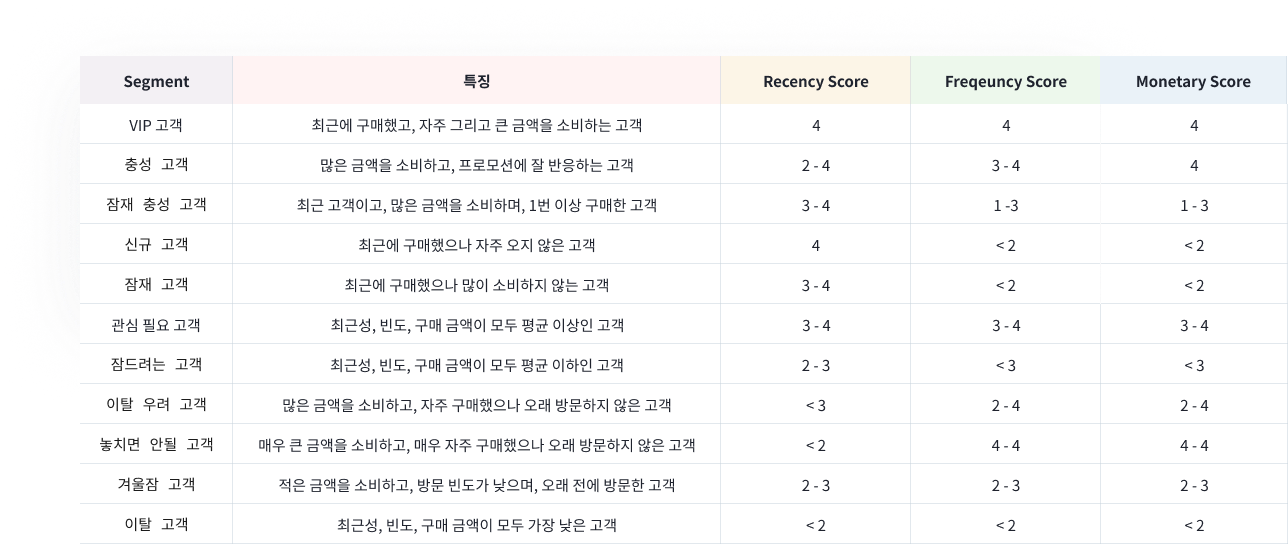

In [152]:
def classify_rfm_segment(r, f, m):
    if r == 4 and f == 4 and m == 4:
        return "VIP 고객"
    elif 2 <= r <= 4 and 3 <= f <= 4 and m == 4:
        return "충성 고객"
    elif 3 <= r <= 4 and 1 <= f <= 3 and 1 <= m <= 3:
        return "잠재 충성 고객"
    elif r == 4 and f <= 2 and m <= 2:
        return "신규 고객"
    elif 3 <= r <= 4 and f <= 2 and m <= 2:
        return "잠재 고객"
    elif 3 <= r <= 4 and 3 <= f <= 4 and 3 <= m <= 4:
        return "관심 필요 고객"
    elif 2 <= r <= 3 and f <= 3 and m <= 3:
        return "잠드려는 고객"
    elif r <= 3 and 2 <= f <= 4 and 2 <= m <= 4:
        return "이탈 우려 고객"
    elif r <= 2 and f == 4 and m == 4:
        return "놓치면 안 될 고객"
    elif 2 <= r <= 3 and 2 <= f <= 3 and 2 <= m <= 3:
        return "겨울잠 고객"
    elif r <= 2 and f <= 2 and m <= 2:
        return "이탈 고객"
    else:
        return "기타 고객"

df['RFM_class'] = df.apply(lambda row: classify_rfm_segment(row['R_score'], row['F_score'], row['M_score']), axis=1)

In [154]:
print(df['RFM_class'].value_counts())

RFM_class
잠재 충성 고객    121648
이탈 우려 고객     77910
잠드려는 고객      69346
충성 고객        56159
이탈 고객        35450
VIP 고객       19616
관심 필요 고객     12683
기타 고객         7188
Name: count, dtype: int64


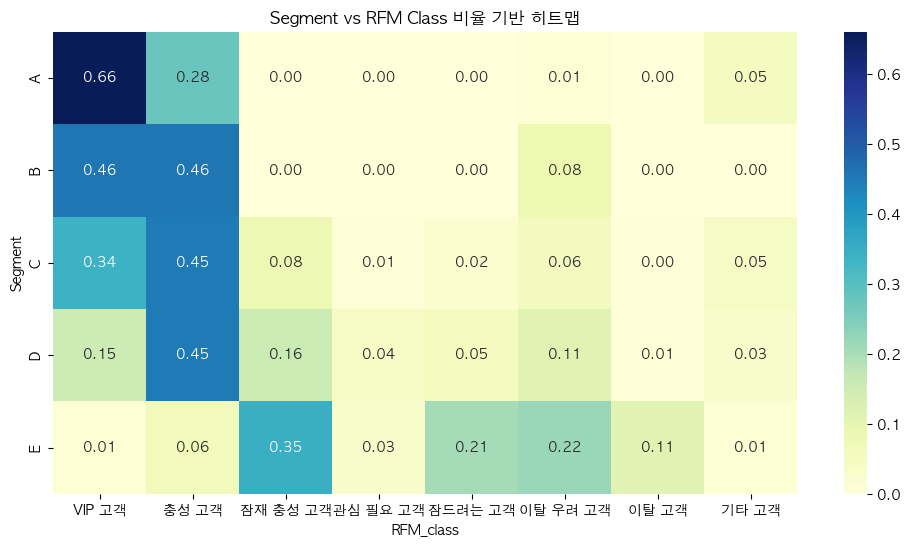

In [156]:
# 정확한 클래스 이름으로 순서 지정
rfm_order = [ "VIP 고객", "충성 고객", "잠재 충성 고객",
    "관심 필요 고객", "잠드려는 고객", "이탈 우려 고객", "이탈 고객", "기타 고객"]
df['RFM_class'] = pd.Categorical(df['RFM_class'], categories=rfm_order, ordered=True)

# 1. 교차표
ct_raw = pd.crosstab(df['Segment'], df['RFM_class'], margins=True)

# 2. 비율 기반 교차표
ct_norm = pd.crosstab(df['Segment'], df['RFM_class'], normalize='index')

# 3. 히트맵 시각화
plt.figure(figsize=(12, 6))
sns.heatmap(ct_norm[rfm_order], annot=True, fmt=".2f", cmap="YlGnBu")  # 컬럼 순서 고정
plt.title("Segment vs RFM Class 비율 기반 히트맵")
plt.show()

## RFM 클러스터링

In [159]:
from sklearn.preprocessing import StandardScaler

rfm_for_cluster = df[['R_score', 'F_score', 'M_score']]  # 또는 RFM 원값
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_for_cluster)

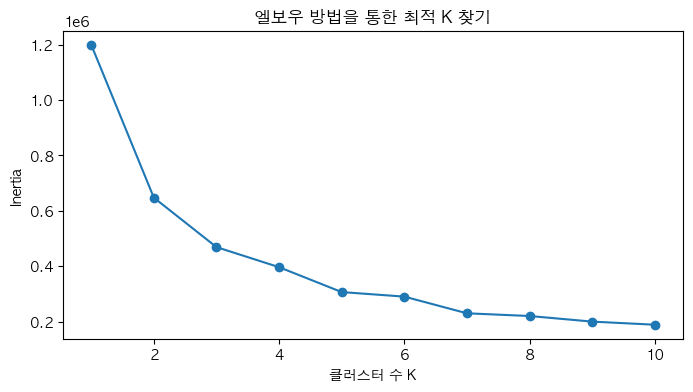

In [161]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('클러스터 수 K')
plt.ylabel('Inertia')
plt.title('엘보우 방법을 통한 최적 K 찾기')
plt.show()

In [162]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
df['KMeans_cluster'] = kmeans.fit_predict(rfm_scaled)

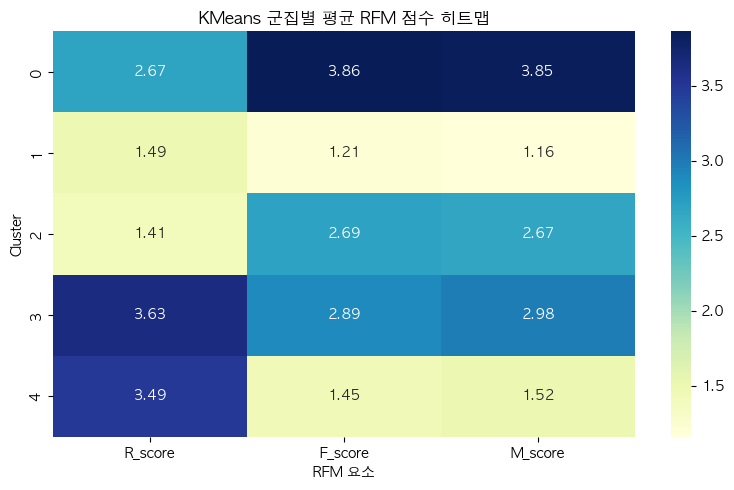

In [163]:
# 숫자형으로 변환
df['R_score'] = df['R_score'].astype(int)
df['F_score'] = df['F_score'].astype(int)
df['M_score'] = df['M_score'].astype(int)

# 이후 군집별 평균 계산
cluster_summary = df.groupby('KMeans_cluster')[['R_score', 'F_score', 'M_score']].mean()

# 히트맵 시각화
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.heatmap(cluster_summary, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("KMeans 군집별 평균 RFM 점수 히트맵")
plt.ylabel("Cluster")
plt.xlabel("RFM 요소")
plt.tight_layout()
plt.show()

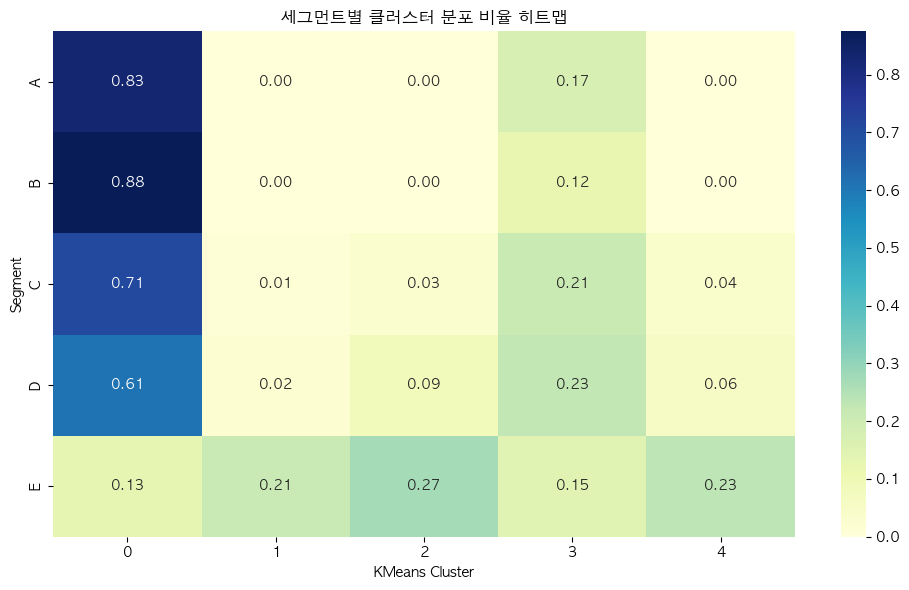

In [167]:
# 1. 교차표: 세그먼트별 클러스터 개수
seg_cluster_ct = pd.crosstab(df['Segment'], df['KMeans_cluster'])

# 2. 세그먼트 기준 정규화 (row-wise 비율)
seg_cluster_ratio = seg_cluster_ct.div(seg_cluster_ct.sum(axis=1), axis=0)

# 3. 히트맵 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(seg_cluster_ratio, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("세그먼트별 클러스터 분포 비율 히트맵")
plt.xlabel("KMeans Cluster")
plt.ylabel("Segment")
plt.tight_layout()
plt.show()